# 🧪 Ambiente R&D: Algoritmi Avanzati di Forecasting per Serie Temporali

**Notebook di Ricerca e Sviluppo**  
*Ambiente professionale per sperimentare algoritmi di forecasting all'avanguardia*

---

## 📋 Obiettivi di Ricerca

Questo notebook serve come ambiente R&D completo per:

1. **🔬 Sperimentazione Algoritmica**: Testare e confrontare nuovi metodi di forecasting
2. **📊 Benchmarking delle Performance**: Valutazione rigorosa attraverso metriche multiple
3. **🎯 Sviluppo di Metodi**: Prototipare e validare approcci innovativi
4. **📈 Ricerca su Modelli Ibridi**: Combinare diverse tecniche per prestazioni migliorate
5. **🔍 Analisi Approfondita**: Capire quando e perché diversi metodi funzionano

---

## 🏗️ Framework di Ricerca

### Algoritmi da Esplorare:
- **Classici**: ARIMA, SARIMA, Exponential Smoothing
- **Machine Learning**: Random Forest, XGBoost, SVR
- **Deep Learning**: LSTM, GRU, modelli basati su Transformer
- **Metodi Ensemble**: Media pesata, stacking, blending
- **Approcci Ibridi**: Combinazioni Statistiche + ML

### Framework di Valutazione:
- **Metriche di Accuratezza**: MAE, RMSE, MAPE, SMAPE
- **Test Statistici**: Diebold-Mariano, Model Confidence Set
- **Robustezza**: Performance attraverso diverse caratteristiche dei dati
- **Efficienza Computazionale**: Tempo di training, utilizzo memoria
- **Interpretabilità**: Spiegabilità del modello e importanza delle feature

## 🔧 Setup e Import

Inizializza l'ambiente di ricerca con tutte le librerie e configurazioni necessarie.

In [1]:
# Librerie core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import time
from typing import Dict, List, Tuple, Any, Optional, Union
from dataclasses import dataclass
from collections import defaultdict
import pickle
import json

# Statistiche e serie temporali
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Librerie ML avanzate (installa se necessario)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  XGBoost non disponibile. Installa con: pip install xgboost")
    XGBOOST_AVAILABLE = False

try:
    from sklearn.svm import SVR
    SVR_AVAILABLE = True
except ImportError:
    SVR_AVAILABLE = False

# Aggiungi percorso progetto per import
project_root = Path().resolve()
if 'notebooks' in str(project_root):
    project_root = project_root.parent
sys.path.insert(0, str(project_root / 'src'))

# Import del progetto
try:
    from arima_forecaster import ARIMAForecaster, SARIMAForecaster
    from arima_forecaster.data import DataLoader, TimeSeriesPreprocessor
    from arima_forecaster.evaluation import ModelEvaluator
    from arima_forecaster.visualization import ForecastPlotter
    from arima_forecaster.core import ARIMAModelSelector, SARIMAModelSelector
    from arima_forecaster.utils import setup_logger
    PROJECT_IMPORTS_OK = True
except ImportError as e:
    print(f"⚠️  Import del progetto non disponibili: {e}")
    print("Esegui questo notebook dalla root del progetto o installa il package in modalità sviluppo")
    PROJECT_IMPORTS_OK = False

# Configurazione
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configurazione ricerca
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Crea directory di output
output_dir = project_root / "outputs" / "research"
output_dir.mkdir(parents=True, exist_ok=True)
plots_dir = output_dir / "plots"
plots_dir.mkdir(exist_ok=True)
models_dir = output_dir / "models"
models_dir.mkdir(exist_ok=True)

print("🔬 Ambiente R&D inizializzato con successo!")
print(f"📁 Directory output: {output_dir}")
print(f"🎯 Random seed: {RANDOM_SEED}")

⚠️  XGBoost non disponibile. Installa con: pip install xgboost
🔬 Ambiente R&D inizializzato con successo!
📁 Directory output: C:\ZCS_PRG\arima_project\outputs\research
🎯 Random seed: 42


## 🏗️ Infrastruttura di Ricerca

Definisce le classi e funzioni core per la sperimentazione algoritmica sistematica.

In [2]:
@dataclass
class ExperimentResult:
    """Contenitore per i risultati degli esperimenti."""
    algorithm_name: str
    parameters: Dict[str, Any]
    training_time: float
    prediction_time: float
    memory_usage: float
    metrics: Dict[str, float]
    predictions: np.ndarray
    model_object: Any = None
    feature_importance: Optional[Dict[str, float]] = None
    confidence_intervals: Optional[np.ndarray] = None
    
class AlgorithmBenchmark:
    """Sistema di benchmarking professionale per algoritmi di serie temporali."""
    
    def __init__(self, random_seed: int = 42):
        self.random_seed = random_seed
        self.results: List[ExperimentResult] = []
        self.datasets: Dict[str, pd.Series] = {}
        
    def add_dataset(self, name: str, data: pd.Series, description: str = ""):
        """Aggiungi un dataset per il benchmarking."""
        self.datasets[name] = {
            'data': data,
            'description': description,
            'length': len(data),
            'frequency': data.index.freq if hasattr(data.index, 'freq') else 'Sconosciuta'
        }
        print(f"📊 Dataset '{name}' aggiunto: {len(data)} osservazioni")
    
    def evaluate_model(self, y_true: np.ndarray, y_pred: np.ndarray, 
                      y_pred_ci: Optional[np.ndarray] = None) -> Dict[str, float]:
        """Metriche complete di valutazione del modello."""
        metrics = {}
        
        # Metriche di accuratezza base
        metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        # MAPE simmetrico (gestisce meglio i valori zero)
        metrics['SMAPE'] = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
        
        # R-squared (coefficiente di determinazione)
        metrics['R2'] = r2_score(y_true, y_pred)
        
        # Accuratezza direzionale (per predizione trend)
        if len(y_true) > 1:
            true_directions = np.diff(y_true) > 0
            pred_directions = np.diff(y_pred) > 0
            metrics['Directional_Accuracy'] = np.mean(true_directions == pred_directions) * 100
        
        # Statistica U di Theil (accuratezza forecast relativa a forecast naïve)
        naive_forecast = y_true[:-1]  # forecast lag-1
        if len(naive_forecast) > 0:
            mse_model = mean_squared_error(y_true[1:], y_pred[1:])
            mse_naive = mean_squared_error(y_true[1:], naive_forecast)
            metrics['Theil_U'] = np.sqrt(mse_model / mse_naive) if mse_naive > 0 else np.inf
        
        # Rapporto di copertura per intervalli di confidenza
        if y_pred_ci is not None and len(y_pred_ci.shape) == 2:
            lower_bound = y_pred_ci[:, 0]
            upper_bound = y_pred_ci[:, 1]
            coverage = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
            metrics['CI_Coverage'] = coverage * 100
            
            # Larghezza media dell'intervallo
            metrics['CI_Width'] = np.mean(upper_bound - lower_bound)
        
        return metrics
    
    def run_experiment(self, algorithm_func, algorithm_name: str, 
                      train_data: pd.Series, test_data: pd.Series,
                      **algorithm_params) -> ExperimentResult:
        """Esegui un singolo esperimento algoritmico."""
        
        print(f"🔬 Eseguendo esperimento: {algorithm_name}")
        
        # Misura tempo di training e memoria
        import psutil
        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024 / 1024  # MB
        
        start_time = time.time()
        
        try:
            # Addestra modello
            model, model_info = algorithm_func(train_data, **algorithm_params)
            training_time = time.time() - start_time
            
            # Misura tempo di predizione
            pred_start = time.time()
            predictions, confidence_intervals = self._get_predictions(model, len(test_data), model_info)
            prediction_time = time.time() - pred_start
            
            # Utilizzo memoria
            mem_after = process.memory_info().rss / 1024 / 1024
            memory_usage = mem_after - mem_before
            
            # Valuta performance
            metrics = self.evaluate_model(test_data.values, predictions, confidence_intervals)
            
            # Importanza feature (se disponibile)
            feature_importance = self._extract_feature_importance(model, model_info)
            
            result = ExperimentResult(
                algorithm_name=algorithm_name,
                parameters=algorithm_params,
                training_time=training_time,
                prediction_time=prediction_time,
                memory_usage=memory_usage,
                metrics=metrics,
                predictions=predictions,
                model_object=model,
                feature_importance=feature_importance,
                confidence_intervals=confidence_intervals
            )
            
            self.results.append(result)
            print(f"✅ {algorithm_name} completato - RMSE: {metrics['RMSE']:.4f}")
            
            return result
            
        except Exception as e:
            print(f"❌ {algorithm_name} fallito: {str(e)}")
            return None
    
    def _get_predictions(self, model, n_steps: int, model_info: Dict) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """Estrai predizioni da diversi tipi di modello."""
        predictions = None
        confidence_intervals = None
        
        model_type = model_info.get('type', 'unknown')
        
        if model_type in ['arima', 'sarima', 'exponential_smoothing']:
            # Modelli statistici
            if hasattr(model, 'forecast'):
                if model_type in ['arima', 'sarima']:
                    forecast_result = model.forecast(steps=n_steps, return_conf_int=True)
                    if isinstance(forecast_result, tuple):
                        predictions = forecast_result[0].values
                        confidence_intervals = forecast_result[1].values
                    else:
                        predictions = forecast_result.values
                else:
                    predictions = model.forecast(steps=n_steps)
            elif hasattr(model, 'predict'):
                predictions = model.predict(start=len(model.model.endog), 
                                          end=len(model.model.endog) + n_steps - 1)
        
        elif model_type in ['sklearn', 'xgboost']:
            # Modelli ML - necessario generare feature
            X_test = model_info.get('X_test')
            if X_test is not None:
                predictions = model.predict(X_test)
        
        return predictions, confidence_intervals
    
    def _extract_feature_importance(self, model, model_info: Dict) -> Optional[Dict[str, float]]:
        """Estrai importanza feature se disponibile."""
        if hasattr(model, 'feature_importances_'):
            feature_names = model_info.get('feature_names', [f'feature_{i}' for i in range(len(model.feature_importances_))])
            return dict(zip(feature_names, model.feature_importances_))
        return None

# Inizializza sistema benchmark
benchmark = AlgorithmBenchmark(random_seed=RANDOM_SEED)
print("🏗️  Infrastruttura di ricerca pronta!")

🏗️  Infrastruttura di ricerca pronta!


## 🔬 Implementazioni Algoritmi

Definisce implementazioni standardizzate di vari algoritmi di forecasting per un confronto equo.

In [3]:
def create_lagged_features(series: pd.Series, n_lags: int = 12, 
                          include_stats: bool = True) -> pd.DataFrame:
    """Crea feature con ritardi per modelli ML."""
    features = pd.DataFrame(index=series.index)
    
    # Valori ritardati
    for lag in range(1, n_lags + 1):
        features[f'lag_{lag}'] = series.shift(lag)
    
    if include_stats:
        # Statistiche rolling
        for window in [3, 7, 30]:
            if window <= len(series):
                features[f'rolling_mean_{window}'] = series.rolling(window).mean().shift(1)
                features[f'rolling_std_{window}'] = series.rolling(window).std().shift(1)
        
        # Feature basate sul tempo
        if hasattr(series.index, 'dayofweek'):
            features['dayofweek'] = series.index.dayofweek
            features['month'] = series.index.month
            features['quarter'] = series.index.quarter
        
        # Feature trend
        features['trend'] = np.arange(len(series))
    
    return features.dropna()

# Implementazioni algoritmi
def experiment_arima(data: pd.Series, order: Tuple[int, int, int] = (1, 1, 1)) -> Tuple[Any, Dict]:
    """Esperimento modello ARIMA."""
    if PROJECT_IMPORTS_OK:
        model = ARIMAForecaster(order=order)
        model.fit(data)
        return model, {'type': 'arima', 'order': order}
    else:
        model = ARIMA(data, order=order).fit()
        return model, {'type': 'arima', 'order': order}

def experiment_sarima(data: pd.Series, order: Tuple[int, int, int] = (1, 1, 1),
                     seasonal_order: Tuple[int, int, int, int] = (1, 1, 1, 12)) -> Tuple[Any, Dict]:
    """Esperimento modello SARIMA."""
    if PROJECT_IMPORTS_OK:
        model = SARIMAForecaster(order=order, seasonal_order=seasonal_order)
        model.fit(data)
        return model, {'type': 'sarima', 'order': order, 'seasonal_order': seasonal_order}
    else:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order).fit()
        return model, {'type': 'sarima', 'order': order, 'seasonal_order': seasonal_order}

def experiment_exponential_smoothing(data: pd.Series, trend: str = 'add', 
                                   seasonal: str = 'add', seasonal_periods: int = 12) -> Tuple[Any, Dict]:
    """Esperimento Exponential Smoothing."""
    model = ExponentialSmoothing(data, trend=trend, seasonal=seasonal, 
                               seasonal_periods=seasonal_periods).fit()
    return model, {'type': 'exponential_smoothing', 'trend': trend, 'seasonal': seasonal}

def experiment_random_forest(data: pd.Series, n_estimators: int = 100, 
                           n_lags: int = 12, test_size: int = 12) -> Tuple[Any, Dict]:
    """Esperimento Random Forest."""
    # Crea feature
    features = create_lagged_features(data, n_lags=n_lags)
    
    # Prepara train/test
    X = features.values[:-test_size]
    y = data.iloc[n_lags:-test_size].values
    X_test = features.values[-test_size:]
    
    # Addestra modello
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=RANDOM_SEED)
    model.fit(X, y)
    
    return model, {
        'type': 'sklearn', 
        'X_test': X_test,
        'feature_names': features.columns.tolist()
    }

def experiment_xgboost(data: pd.Series, n_estimators: int = 100, 
                      n_lags: int = 12, test_size: int = 12) -> Tuple[Any, Dict]:
    """Esperimento XGBoost."""
    if not XGBOOST_AVAILABLE:
        raise ImportError("XGBoost non disponibile")
    
    # Crea feature
    features = create_lagged_features(data, n_lags=n_lags)
    
    # Prepara train/test
    X = features.values[:-test_size]
    y = data.iloc[n_lags:-test_size].values
    X_test = features.values[-test_size:]
    
    # Addestra modello
    model = xgb.XGBRegressor(n_estimators=n_estimators, random_state=RANDOM_SEED)
    model.fit(X, y)
    
    return model, {
        'type': 'xgboost', 
        'X_test': X_test,
        'feature_names': features.columns.tolist()
    }

def experiment_svr(data: pd.Series, kernel: str = 'rbf', n_lags: int = 12, 
                  test_size: int = 12) -> Tuple[Any, Dict]:
    """Esperimento Support Vector Regression."""
    # Crea feature
    features = create_lagged_features(data, n_lags=n_lags)
    
    # Prepara train/test
    X = features.values[:-test_size]
    y = data.iloc[n_lags:-test_size].values
    X_test = features.values[-test_size:]
    
    # Scala feature per SVR
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Addestra modello
    model = SVR(kernel=kernel)
    model.fit(X_scaled, y)
    
    # Wrappa modello con scaler
    class ScaledSVR:
        def __init__(self, model, scaler):
            self.model = model
            self.scaler = scaler
        
        def predict(self, X):
            return self.model.predict(self.scaler.transform(X))
    
    wrapped_model = ScaledSVR(model, scaler)
    
    return wrapped_model, {
        'type': 'sklearn',
        'X_test': X_test,  # Usa non scalati per consistenza
        'feature_names': features.columns.tolist()
    }

print("🧪 Implementazioni algoritmi pronte!")

🧪 Implementazioni algoritmi pronte!


## 📊 Generazione e Preparazione Dataset

Crea dataset sintetici diversi con caratteristiche differenti per testare la robustezza degli algoritmi.

📊 Generazione dataset di ricerca...
📊 Dataset 'Linear_Stagionale' aggiunto: 300 osservazioni
📊 Dataset 'Crescita_Esponenziale' aggiunto: 200 osservazioni
📊 Dataset 'Rumoroso_Anomalie' aggiunto: 250 osservazioni
📊 Dataset 'Stazionaria' aggiunto: 200 osservazioni
📊 Dataset 'Polinomiale' aggiunto: 300 osservazioni


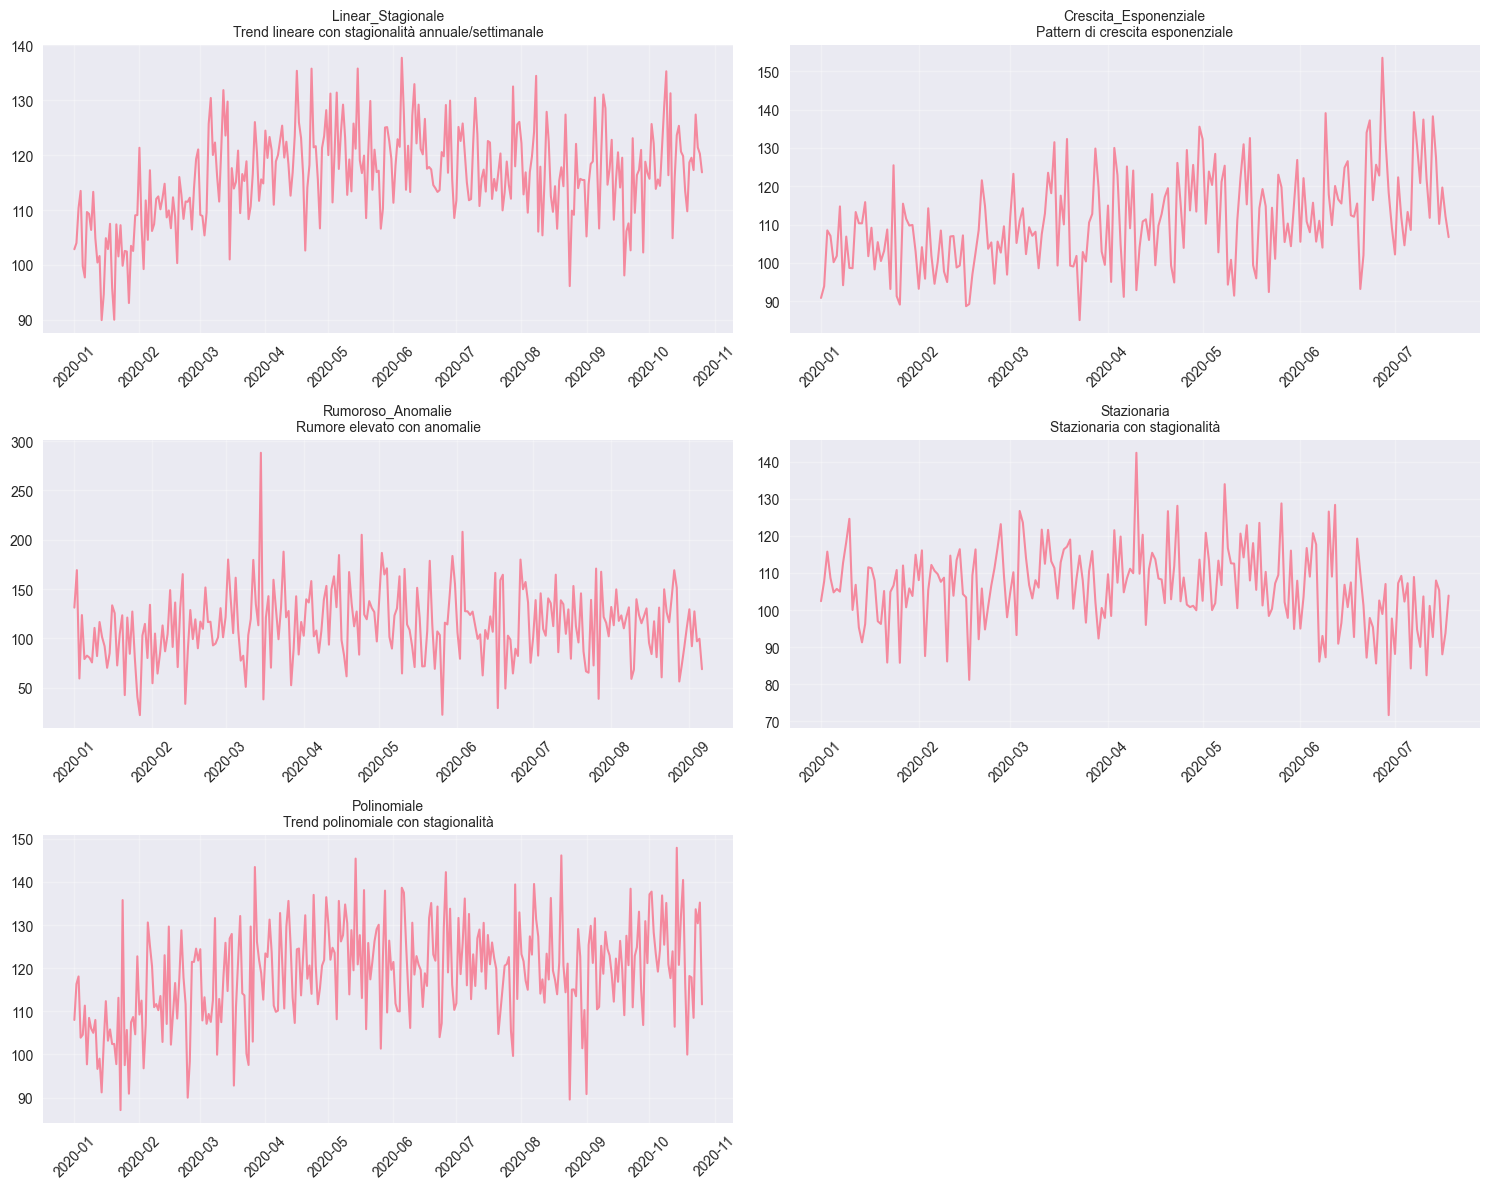

📊 Generati 5 dataset di ricerca
  • Linear_Stagionale: 300 osservazioni - Trend lineare con stagionalità annuale/settimanale
  • Crescita_Esponenziale: 200 osservazioni - Pattern di crescita esponenziale
  • Rumoroso_Anomalie: 250 osservazioni - Rumore elevato con anomalie
  • Stazionaria: 200 osservazioni - Stazionaria con stagionalità
  • Polinomiale: 300 osservazioni - Trend polinomiale con stagionalità


In [4]:
def generate_synthetic_ts(name: str, n_periods: int = 200, freq: str = 'D', 
                         trend_type: str = 'linear', seasonality: bool = True,
                         noise_level: float = 0.1, anomalies: bool = False) -> pd.Series:
    """Genera serie temporali sintetiche con caratteristiche specificate."""
    
    dates = pd.date_range('2020-01-01', periods=n_periods, freq=freq)
    t = np.arange(n_periods)
    
    # Trend di base
    if trend_type == 'linear':
        trend = 0.1 * t + 100
    elif trend_type == 'exponential':
        trend = 100 * np.exp(0.001 * t)
    elif trend_type == 'polynomial':
        trend = 100 + 0.1 * t + 0.0001 * t**2
    elif trend_type == 'none':
        trend = np.full(n_periods, 100)
    else:
        trend = np.full(n_periods, 100)
    
    # Stagionalità
    seasonal = np.zeros(n_periods)
    if seasonality:
        # Stagionalità annuale
        seasonal += 10 * np.sin(2 * np.pi * t / 365.25)
        # Stagionalità settimanale (se frequenza giornaliera)
        if freq == 'D':
            seasonal += 5 * np.sin(2 * np.pi * t / 7)
        # Stagionalità mensile (se frequenza maggiore)
        if freq in ['D', 'H']:
            seasonal += 3 * np.sin(2 * np.pi * t / 30.44)
    
    # Rumore
    noise = np.random.normal(0, noise_level * np.mean(trend), n_periods)
    
    # Combina componenti
    series = trend + seasonal + noise
    
    # Aggiungi anomalie
    if anomalies:
        n_anomalies = max(1, n_periods // 50)  # ~2% anomalie
        anomaly_idx = np.random.choice(n_periods, n_anomalies, replace=False)
        for idx in anomaly_idx:
            series[idx] *= np.random.choice([0.5, 1.5, 2.0])  # Moltiplicatore anomalia
    
    return pd.Series(series, index=dates, name=name)

# Genera dataset di ricerca
print("📊 Generazione dataset di ricerca...")

# Dataset 1: Trend lineare semplice con stagionalità
ts_linear = generate_synthetic_ts(
    'linear_seasonal', 
    n_periods=300, 
    trend_type='linear',
    seasonality=True,
    noise_level=0.05
)
benchmark.add_dataset('Linear_Stagionale', ts_linear, 'Trend lineare con stagionalità annuale/settimanale')

# Dataset 2: Crescita esponenziale
ts_exponential = generate_synthetic_ts(
    'exponential_growth',
    n_periods=200,
    trend_type='exponential',
    seasonality=False,
    noise_level=0.1
)
benchmark.add_dataset('Crescita_Esponenziale', ts_exponential, 'Pattern di crescita esponenziale')

# Dataset 3: Rumore elevato con anomalie
ts_noisy = generate_synthetic_ts(
    'noisy_anomalies',
    n_periods=250,
    trend_type='linear',
    seasonality=True,
    noise_level=0.3,
    anomalies=True
)
benchmark.add_dataset('Rumoroso_Anomalie', ts_noisy, 'Rumore elevato con anomalie')

# Dataset 4: Serie stazionaria (senza trend)
ts_stationary = generate_synthetic_ts(
    'stationary',
    n_periods=200,
    trend_type='none',
    seasonality=True,
    noise_level=0.1
)
benchmark.add_dataset('Stazionaria', ts_stationary, 'Stazionaria con stagionalità')

# Dataset 5: Trend polinomiale complesso
ts_polynomial = generate_synthetic_ts(
    'polynomial',
    n_periods=300,
    trend_type='polynomial',
    seasonality=True,
    noise_level=0.08
)
benchmark.add_dataset('Polinomiale', ts_polynomial, 'Trend polinomiale con stagionalità')

# Visualizza dataset
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (name, dataset) in enumerate(benchmark.datasets.items()):
    if i < 5:
        ax = axes[i]
        data = dataset['data']
        ax.plot(data.index, data.values, linewidth=1.5, alpha=0.8)
        ax.set_title(f'{name}\n{dataset["description"]}', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

# Rimuovi subplot vuoto
axes[5].remove()

plt.tight_layout()
plt.savefig(plots_dir / 'dataset_ricerca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Generati {len(benchmark.datasets)} dataset di ricerca")
for name, dataset in benchmark.datasets.items():
    print(f"  • {name}: {dataset['length']} osservazioni - {dataset['description']}")

## 🧪 Esperimenti Algoritmi Completi

Esegue esperimenti sistematici attraverso tutti gli algoritmi e dataset con valutazione rigorosa.

In [5]:
# Configurazione esperimenti
TEST_SIZE = 30  # Numero di periodi per test out-of-sample
experiments_config = [
    ('ARIMA_111', experiment_arima, {'order': (1, 1, 1)}),
    ('ARIMA_212', experiment_arima, {'order': (2, 1, 2)}),
    ('SARIMA_111_1111_12', experiment_sarima, {
        'order': (1, 1, 1), 
        'seasonal_order': (1, 1, 1, 12)
    }),
    ('ExpSmoothing_Add', experiment_exponential_smoothing, {
        'trend': 'add', 
        'seasonal': 'add', 
        'seasonal_periods': 12
    }),
    ('RandomForest_100', experiment_random_forest, {
        'n_estimators': 100, 
        'n_lags': 12, 
        'test_size': TEST_SIZE
    }),
    ('RandomForest_500', experiment_random_forest, {
        'n_estimators': 500, 
        'n_lags': 20, 
        'test_size': TEST_SIZE
    }),
]

# Aggiungi XGBoost se disponibile
if XGBOOST_AVAILABLE:
    experiments_config.extend([
        ('XGBoost_100', experiment_xgboost, {
            'n_estimators': 100, 
            'n_lags': 12, 
            'test_size': TEST_SIZE
        }),
        ('XGBoost_300', experiment_xgboost, {
            'n_estimators': 300, 
            'n_lags': 20, 
            'test_size': TEST_SIZE
        }),
    ])

# Aggiungi SVR se disponibile
if SVR_AVAILABLE:
    experiments_config.extend([
        ('SVR_RBF', experiment_svr, {
            'kernel': 'rbf', 
            'n_lags': 12, 
            'test_size': TEST_SIZE
        }),
        ('SVR_Linear', experiment_svr, {
            'kernel': 'linear', 
            'n_lags': 12, 
            'test_size': TEST_SIZE
        }),
    ])

print(f"🔬 Esecuzione di {len(experiments_config)} algoritmi su {len(benchmark.datasets)} dataset")
print(f"📊 Esperimenti totali: {len(experiments_config) * len(benchmark.datasets)}")

# Esegui tutti gli esperimenti
results_matrix = []
experiment_counter = 0
total_experiments = len(experiments_config) * len(benchmark.datasets)

for dataset_name, dataset_info in benchmark.datasets.items():
    print(f"\n📊 Dataset: {dataset_name}")
    print("=" * 50)
    
    data = dataset_info['data']
    train_data = data[:-TEST_SIZE]
    test_data = data[-TEST_SIZE:]
    
    dataset_results = []
    
    for algo_name, algo_func, algo_params in experiments_config:
        experiment_counter += 1
        print(f"\n[{experiment_counter}/{total_experiments}] {algo_name} su {dataset_name}")
        
        try:
            result = benchmark.run_experiment(
                algo_func, algo_name, train_data, test_data, **algo_params
            )
            
            if result:
                dataset_results.append(result)
                
                # Aggiungi alla matrice risultati
                results_matrix.append({
                    'Dataset': dataset_name,
                    'Algoritmo': algo_name,
                    'RMSE': result.metrics['RMSE'],
                    'MAE': result.metrics['MAE'],
                    'MAPE': result.metrics['MAPE'],
                    'R2': result.metrics['R2'],
                    'Tempo_Training': result.training_time,
                    'Tempo_Predizione': result.prediction_time,
                    'Memoria_MB': result.memory_usage
                })
            
        except Exception as e:
            print(f"⚠️  Esperimento fallito: {e}")
            continue

print(f"\n✅ Completati {len(results_matrix)} esperimenti con successo")

# Crea DataFrame risultati
results_df = pd.DataFrame(results_matrix)
print(f"📊 Matrice risultati shape: {results_df.shape}")

2025-08-21 17:42:59,259 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(1, 1, 1) model to 270 observations


2025-08-21 17:42:59,287 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:42:59,287 - arima_forecaster.core.arima_model - INFO - AIC: 1820.35


2025-08-21 17:42:59,293 - arima_forecaster.core.arima_model - INFO - BIC: 1831.14


2025-08-21 17:42:59,294 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:42:59,297 - arima_forecaster.core.arima_model - INFO - Forecast generato: 114.95 a 114.39


2025-08-21 17:42:59,297 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(2, 1, 2) model to 270 observations


2025-08-21 17:42:59,390 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:42:59,390 - arima_forecaster.core.arima_model - INFO - AIC: 1821.10


2025-08-21 17:42:59,399 - arima_forecaster.core.arima_model - INFO - BIC: 1839.08


2025-08-21 17:42:59,399 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:42:59,399 - arima_forecaster.core.arima_model - INFO - Forecast generato: 114.14 a 114.28


2025-08-21 17:42:59,405 - arima_forecaster.core.sarima_model - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model to 270 observations


2025-08-21 17:42:59,405 - arima_forecaster.core.sarima_model - WARNING - Daily data with seasonal period 12 may not be appropriate. Consider 7 (weekly), 30 (monthly), or 365 (yearly).


🔬 Esecuzione di 8 algoritmi su 5 dataset
📊 Esperimenti totali: 40

📊 Dataset: Linear_Stagionale

[1/40] ARIMA_111 su Linear_Stagionale
🔬 Eseguendo esperimento: ARIMA_111
✅ ARIMA_111 completato - RMSE: 8.3465

[2/40] ARIMA_212 su Linear_Stagionale
🔬 Eseguendo esperimento: ARIMA_212
✅ ARIMA_212 completato - RMSE: 8.4494

[3/40] SARIMA_111_1111_12 su Linear_Stagionale
🔬 Eseguendo esperimento: SARIMA_111_1111_12


2025-08-21 17:43:00,085 - arima_forecaster.core.sarima_model - INFO - SARIMA model fitted successfully


2025-08-21 17:43:00,085 - arima_forecaster.core.sarima_model - INFO - AIC: 1780.06


2025-08-21 17:43:00,085 - arima_forecaster.core.sarima_model - INFO - BIC: 1797.81


2025-08-21 17:43:00,085 - arima_forecaster.core.sarima_model - INFO - Generating 30-step SARIMA forecast


2025-08-21 17:43:00,097 - arima_forecaster.core.sarima_model - INFO - SARIMA forecast generated: 116.87 to 116.84


2025-08-21 17:43:00,223 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(1, 1, 1) model to 170 observations


2025-08-21 17:43:00,260 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:00,264 - arima_forecaster.core.arima_model - INFO - AIC: 1282.98


2025-08-21 17:43:00,264 - arima_forecaster.core.arima_model - INFO - BIC: 1292.37


2025-08-21 17:43:00,264 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:00,266 - arima_forecaster.core.arima_model - INFO - Forecast generato: 114.93 a 115.07


2025-08-21 17:43:00,271 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(2, 1, 2) model to 170 observations


✅ SARIMA_111_1111_12 completato - RMSE: 7.7516

[4/40] ExpSmoothing_Add su Linear_Stagionale
🔬 Eseguendo esperimento: ExpSmoothing_Add
✅ ExpSmoothing_Add completato - RMSE: 7.8907

[5/40] RandomForest_100 su Linear_Stagionale
🔬 Eseguendo esperimento: RandomForest_100
❌ RandomForest_100 fallito: Found input variables with inconsistent numbers of samples: [210, 228]

[6/40] RandomForest_500 su Linear_Stagionale
🔬 Eseguendo esperimento: RandomForest_500
❌ RandomForest_500 fallito: Found input variables with inconsistent numbers of samples: [210, 220]

[7/40] SVR_RBF su Linear_Stagionale
🔬 Eseguendo esperimento: SVR_RBF
❌ SVR_RBF fallito: Found input variables with inconsistent numbers of samples: [210, 228]

[8/40] SVR_Linear su Linear_Stagionale
🔬 Eseguendo esperimento: SVR_Linear
❌ SVR_Linear fallito: Found input variables with inconsistent numbers of samples: [210, 228]

📊 Dataset: Crescita_Esponenziale

[9/40] ARIMA_111 su Crescita_Esponenziale
🔬 Eseguendo esperimento: ARIMA_111
✅ ARI

2025-08-21 17:43:00,415 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:00,415 - arima_forecaster.core.arima_model - INFO - AIC: 1286.74


2025-08-21 17:43:00,415 - arima_forecaster.core.arima_model - INFO - BIC: 1302.39


2025-08-21 17:43:00,415 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:00,425 - arima_forecaster.core.arima_model - INFO - Forecast generato: 114.64 a 114.99


2025-08-21 17:43:00,425 - arima_forecaster.core.sarima_model - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model to 170 observations


2025-08-21 17:43:00,425 - arima_forecaster.core.sarima_model - WARNING - Daily data with seasonal period 12 may not be appropriate. Consider 7 (weekly), 30 (monthly), or 365 (yearly).


✅ ARIMA_212 completato - RMSE: 14.2892

[11/40] SARIMA_111_1111_12 su Crescita_Esponenziale
🔬 Eseguendo esperimento: SARIMA_111_1111_12


2025-08-21 17:43:01,003 - arima_forecaster.core.sarima_model - INFO - SARIMA model fitted successfully


2025-08-21 17:43:01,003 - arima_forecaster.core.sarima_model - INFO - AIC: 1225.30


2025-08-21 17:43:01,003 - arima_forecaster.core.sarima_model - INFO - BIC: 1240.58


2025-08-21 17:43:01,003 - arima_forecaster.core.sarima_model - INFO - Generating 30-step SARIMA forecast


2025-08-21 17:43:01,003 - arima_forecaster.core.sarima_model - INFO - SARIMA forecast generated: 122.29 to 117.51


2025-08-21 17:43:01,084 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(1, 1, 1) model to 220 observations


2025-08-21 17:43:01,125 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:01,125 - arima_forecaster.core.arima_model - INFO - AIC: 2210.44


2025-08-21 17:43:01,125 - arima_forecaster.core.arima_model - INFO - BIC: 2220.60


2025-08-21 17:43:01,125 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:01,130 - arima_forecaster.core.arima_model - INFO - Forecast generato: 116.00 a 116.50


2025-08-21 17:43:01,130 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(2, 1, 2) model to 220 observations


✅ SARIMA_111_1111_12 completato - RMSE: 14.5838

[12/40] ExpSmoothing_Add su Crescita_Esponenziale
🔬 Eseguendo esperimento: ExpSmoothing_Add
✅ ExpSmoothing_Add completato - RMSE: 14.6668

[13/40] RandomForest_100 su Crescita_Esponenziale
🔬 Eseguendo esperimento: RandomForest_100
❌ RandomForest_100 fallito: Found input variables with inconsistent numbers of samples: [110, 128]

[14/40] RandomForest_500 su Crescita_Esponenziale
🔬 Eseguendo esperimento: RandomForest_500
❌ RandomForest_500 fallito: Found input variables with inconsistent numbers of samples: [110, 120]

[15/40] SVR_RBF su Crescita_Esponenziale
🔬 Eseguendo esperimento: SVR_RBF
❌ SVR_RBF fallito: Found input variables with inconsistent numbers of samples: [110, 128]

[16/40] SVR_Linear su Crescita_Esponenziale
🔬 Eseguendo esperimento: SVR_Linear
❌ SVR_Linear fallito: Found input variables with inconsistent numbers of samples: [110, 128]

📊 Dataset: Rumoroso_Anomalie

[17/40] ARIMA_111 su Rumoroso_Anomalie
🔬 Eseguendo esperime

2025-08-21 17:43:01,226 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:01,226 - arima_forecaster.core.arima_model - INFO - AIC: 2213.23


2025-08-21 17:43:01,226 - arima_forecaster.core.arima_model - INFO - BIC: 2230.18


2025-08-21 17:43:01,226 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:01,241 - arima_forecaster.core.arima_model - INFO - Forecast generato: 119.28 a 116.61


2025-08-21 17:43:01,241 - arima_forecaster.core.sarima_model - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model to 220 observations


2025-08-21 17:43:01,241 - arima_forecaster.core.sarima_model - WARNING - Daily data with seasonal period 12 may not be appropriate. Consider 7 (weekly), 30 (monthly), or 365 (yearly).


✅ ARIMA_212 completato - RMSE: 30.7887

[19/40] SARIMA_111_1111_12 su Rumoroso_Anomalie
🔬 Eseguendo esperimento: SARIMA_111_1111_12


2025-08-21 17:43:01,807 - arima_forecaster.core.sarima_model - INFO - SARIMA model fitted successfully


2025-08-21 17:43:01,807 - arima_forecaster.core.sarima_model - INFO - AIC: 2135.99


2025-08-21 17:43:01,807 - arima_forecaster.core.sarima_model - INFO - BIC: 2152.65


2025-08-21 17:43:01,807 - arima_forecaster.core.sarima_model - INFO - Generating 30-step SARIMA forecast


2025-08-21 17:43:01,807 - arima_forecaster.core.sarima_model - INFO - SARIMA forecast generated: 130.15 to 136.05


2025-08-21 17:43:01,917 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(1, 1, 1) model to 170 observations


2025-08-21 17:43:01,951 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:01,951 - arima_forecaster.core.arima_model - INFO - AIC: 1268.98


2025-08-21 17:43:01,951 - arima_forecaster.core.arima_model - INFO - BIC: 1278.37


2025-08-21 17:43:01,951 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:01,960 - arima_forecaster.core.arima_model - INFO - Forecast generato: 106.50 a 106.84


2025-08-21 17:43:01,962 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(2, 1, 2) model to 170 observations


✅ SARIMA_111_1111_12 completato - RMSE: 31.5000

[20/40] ExpSmoothing_Add su Rumoroso_Anomalie
🔬 Eseguendo esperimento: ExpSmoothing_Add
✅ ExpSmoothing_Add completato - RMSE: 29.8776

[21/40] RandomForest_100 su Rumoroso_Anomalie
🔬 Eseguendo esperimento: RandomForest_100
❌ RandomForest_100 fallito: Found input variables with inconsistent numbers of samples: [160, 178]

[22/40] RandomForest_500 su Rumoroso_Anomalie
🔬 Eseguendo esperimento: RandomForest_500
❌ RandomForest_500 fallito: Found input variables with inconsistent numbers of samples: [160, 170]

[23/40] SVR_RBF su Rumoroso_Anomalie
🔬 Eseguendo esperimento: SVR_RBF
❌ SVR_RBF fallito: Found input variables with inconsistent numbers of samples: [160, 178]

[24/40] SVR_Linear su Rumoroso_Anomalie
🔬 Eseguendo esperimento: SVR_Linear
❌ SVR_Linear fallito: Found input variables with inconsistent numbers of samples: [160, 178]

📊 Dataset: Stazionaria

[25/40] ARIMA_111 su Stazionaria
🔬 Eseguendo esperimento: ARIMA_111
✅ ARIMA_111 compl

2025-08-21 17:43:02,063 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:02,063 - arima_forecaster.core.arima_model - INFO - AIC: 1269.25


2025-08-21 17:43:02,063 - arima_forecaster.core.arima_model - INFO - BIC: 1284.90


2025-08-21 17:43:02,063 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:02,070 - arima_forecaster.core.arima_model - INFO - Forecast generato: 107.21 a 107.47


2025-08-21 17:43:02,070 - arima_forecaster.core.sarima_model - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model to 170 observations


2025-08-21 17:43:02,070 - arima_forecaster.core.sarima_model - WARNING - Daily data with seasonal period 12 may not be appropriate. Consider 7 (weekly), 30 (monthly), or 365 (yearly).


✅ ARIMA_212 completato - RMSE: 13.7676

[27/40] SARIMA_111_1111_12 su Stazionaria
🔬 Eseguendo esperimento: SARIMA_111_1111_12


2025-08-21 17:43:02,418 - arima_forecaster.core.sarima_model - INFO - SARIMA model fitted successfully


2025-08-21 17:43:02,418 - arima_forecaster.core.sarima_model - INFO - AIC: 1222.91


2025-08-21 17:43:02,418 - arima_forecaster.core.sarima_model - INFO - BIC: 1238.19


2025-08-21 17:43:02,418 - arima_forecaster.core.sarima_model - INFO - Generating 30-step SARIMA forecast


2025-08-21 17:43:02,418 - arima_forecaster.core.sarima_model - INFO - SARIMA forecast generated: 107.47 to 108.71


2025-08-21 17:43:02,522 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(1, 1, 1) model to 270 observations


2025-08-21 17:43:02,552 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:02,552 - arima_forecaster.core.arima_model - INFO - AIC: 2025.96


2025-08-21 17:43:02,552 - arima_forecaster.core.arima_model - INFO - BIC: 2036.74


2025-08-21 17:43:02,552 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:02,566 - arima_forecaster.core.arima_model - INFO - Forecast generato: 121.32 a 121.46


2025-08-21 17:43:02,568 - arima_forecaster.core.arima_model - INFO - Fitting ARIMA(2, 1, 2) model to 270 observations


✅ SARIMA_111_1111_12 completato - RMSE: 13.6400

[28/40] ExpSmoothing_Add su Stazionaria
🔬 Eseguendo esperimento: ExpSmoothing_Add
✅ ExpSmoothing_Add completato - RMSE: 15.9601

[29/40] RandomForest_100 su Stazionaria
🔬 Eseguendo esperimento: RandomForest_100
❌ RandomForest_100 fallito: Found input variables with inconsistent numbers of samples: [110, 128]

[30/40] RandomForest_500 su Stazionaria
🔬 Eseguendo esperimento: RandomForest_500
❌ RandomForest_500 fallito: Found input variables with inconsistent numbers of samples: [110, 120]

[31/40] SVR_RBF su Stazionaria
🔬 Eseguendo esperimento: SVR_RBF
❌ SVR_RBF fallito: Found input variables with inconsistent numbers of samples: [110, 128]

[32/40] SVR_Linear su Stazionaria
🔬 Eseguendo esperimento: SVR_Linear
❌ SVR_Linear fallito: Found input variables with inconsistent numbers of samples: [110, 128]

📊 Dataset: Polinomiale

[33/40] ARIMA_111 su Polinomiale
🔬 Eseguendo esperimento: ARIMA_111
✅ ARIMA_111 completato - RMSE: 11.5147

[34/40]

2025-08-21 17:43:02,718 - arima_forecaster.core.arima_model - INFO - Modello ARIMA addestrato con successo


2025-08-21 17:43:02,718 - arima_forecaster.core.arima_model - INFO - AIC: 2028.46


2025-08-21 17:43:02,718 - arima_forecaster.core.arima_model - INFO - BIC: 2046.44


2025-08-21 17:43:02,718 - arima_forecaster.core.arima_model - INFO - Generazione forecast a 30 passi


2025-08-21 17:43:02,718 - arima_forecaster.core.arima_model - INFO - Forecast generato: 121.24 a 121.38


2025-08-21 17:43:02,725 - arima_forecaster.core.sarima_model - INFO - Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) model to 270 observations


2025-08-21 17:43:02,725 - arima_forecaster.core.sarima_model - WARNING - Daily data with seasonal period 12 may not be appropriate. Consider 7 (weekly), 30 (monthly), or 365 (yearly).


✅ ARIMA_212 completato - RMSE: 11.5814

[35/40] SARIMA_111_1111_12 su Polinomiale
🔬 Eseguendo esperimento: SARIMA_111_1111_12


2025-08-21 17:43:03,370 - arima_forecaster.core.sarima_model - INFO - SARIMA model fitted successfully


2025-08-21 17:43:03,370 - arima_forecaster.core.sarima_model - INFO - AIC: 1977.98


2025-08-21 17:43:03,370 - arima_forecaster.core.sarima_model - INFO - BIC: 1995.72


2025-08-21 17:43:03,370 - arima_forecaster.core.sarima_model - INFO - Generating 30-step SARIMA forecast


2025-08-21 17:43:03,376 - arima_forecaster.core.sarima_model - INFO - SARIMA forecast generated: 123.76 to 124.53


✅ SARIMA_111_1111_12 completato - RMSE: 11.4059

[36/40] ExpSmoothing_Add su Polinomiale
🔬 Eseguendo esperimento: ExpSmoothing_Add
✅ ExpSmoothing_Add completato - RMSE: 12.2788

[37/40] RandomForest_100 su Polinomiale
🔬 Eseguendo esperimento: RandomForest_100
❌ RandomForest_100 fallito: Found input variables with inconsistent numbers of samples: [210, 228]

[38/40] RandomForest_500 su Polinomiale
🔬 Eseguendo esperimento: RandomForest_500
❌ RandomForest_500 fallito: Found input variables with inconsistent numbers of samples: [210, 220]

[39/40] SVR_RBF su Polinomiale
🔬 Eseguendo esperimento: SVR_RBF
❌ SVR_RBF fallito: Found input variables with inconsistent numbers of samples: [210, 228]

[40/40] SVR_Linear su Polinomiale
🔬 Eseguendo esperimento: SVR_Linear
❌ SVR_Linear fallito: Found input variables with inconsistent numbers of samples: [210, 228]

✅ Completati 20 esperimenti con successo
📊 Matrice risultati shape: (20, 9)


## 📈 Analisi Performance e Visualizzazione

Analisi completa dei risultati sperimentali con visualizzazioni professionali.

In [6]:
# Statistiche Riassuntive Performance
print("📊 RIASSUNTO RISULTATI ESPERIMENTI")
print("=" * 60)

if len(results_df) > 0:
    # Classifica performance generale
    print("\n🏆 Classifica Algoritmi Generale (per RMSE Medio):")
    avg_performance = results_df.groupby('Algoritmo').agg({
        'RMSE': ['mean', 'std', 'min', 'max'],
        'MAE': ['mean', 'std'],
        'R2': ['mean', 'std'],
        'Tempo_Training': ['mean', 'std'],
        'Memoria_MB': ['mean', 'std']
    }).round(4)
    
    avg_performance.columns = ['_'.join(col).strip() for col in avg_performance.columns]
    ranking = avg_performance.sort_values('RMSE_mean')
    
    for i, (algo, row) in enumerate(ranking.iterrows(), 1):
        print(f"{i:2d}. {algo:20s} - RMSE: {row['RMSE_mean']:8.4f} (±{row['RMSE_std']:6.4f}) | "
              f"R²: {row['R2_mean']:6.3f} | Tempo: {row['Tempo_Training_mean']:6.2f}s")
    
    # Analisi difficoltà dataset
    print("\n📊 Classifica Difficoltà Dataset (per RMSE Medio):")
    dataset_difficulty = results_df.groupby('Dataset')['RMSE'].agg(['mean', 'std']).round(4)
    dataset_difficulty = dataset_difficulty.sort_values('mean', ascending=False)
    
    for i, (dataset, row) in enumerate(dataset_difficulty.iterrows(), 1):
        print(f"{i}. {dataset:20s} - RMSE Medio: {row['mean']:8.4f} (±{row['std']:6.4f})")
    
    # Miglior algoritmo per dataset
    print("\n🎯 Miglior Algoritmo per Dataset:")
    best_per_dataset = results_df.loc[results_df.groupby('Dataset')['RMSE'].idxmin()]
    
    for _, row in best_per_dataset.iterrows():
        print(f"{row['Dataset']:20s} → {row['Algoritmo']:20s} (RMSE: {row['RMSE']:7.4f})")
    
    # Analisi Performance vs Efficienza
    print("\n⚡ Analisi Performance vs Efficienza:")
    efficiency_df = results_df.groupby('Algoritmo').agg({
        'RMSE': 'mean',
        'Tempo_Training': 'mean',
        'Memoria_MB': 'mean'
    }).round(4)
    
    # Normalizza metriche per confronto (più basso è meglio per tutti)
    efficiency_df['RMSE_norm'] = (efficiency_df['RMSE'] - efficiency_df['RMSE'].min()) / (efficiency_df['RMSE'].max() - efficiency_df['RMSE'].min())
    efficiency_df['Tempo_norm'] = (efficiency_df['Tempo_Training'] - efficiency_df['Tempo_Training'].min()) / (efficiency_df['Tempo_Training'].max() - efficiency_df['Tempo_Training'].min())
    efficiency_df['Memoria_norm'] = (efficiency_df['Memoria_MB'] - efficiency_df['Memoria_MB'].min()) / (efficiency_df['Memoria_MB'].max() - efficiency_df['Memoria_MB'].min())
    
    # Punteggio efficienza combinato (più basso è meglio)
    efficiency_df['Punteggio_Efficienza'] = (efficiency_df['RMSE_norm'] + efficiency_df['Tempo_norm'] + efficiency_df['Memoria_norm']) / 3
    efficiency_ranking = efficiency_df.sort_values('Punteggio_Efficienza')
    
    for i, (algo, row) in enumerate(efficiency_ranking.iterrows(), 1):
        print(f"{i:2d}. {algo:20s} - Punteggio: {row['Punteggio_Efficienza']:5.3f} | "
              f"RMSE: {row['RMSE']:7.4f} | Tempo: {row['Tempo_Training']:6.2f}s | Memoria: {row['Memoria_MB']:5.1f}MB")

else:
    print("❌ Nessun esperimento riuscito da analizzare")

📊 RIASSUNTO RISULTATI ESPERIMENTI

🏆 Classifica Algoritmi Generale (per RMSE Medio):
 1. ARIMA_111            - RMSE:  15.6624 (±8.7815) | R²: -0.293 | Tempo:   0.04s
 2. ARIMA_212            - RMSE:  15.7753 (±8.7020) | R²: -0.325 | Tempo:   0.12s
 3. SARIMA_111_1111_12   - RMSE:  15.7762 (±9.1749) | R²: -0.283 | Tempo:   0.56s
 4. ExpSmoothing_Add     - RMSE:  16.1348 (±8.2747) | R²: -0.439 | Tempo:   0.08s

📊 Classifica Difficoltà Dataset (per RMSE Medio):
1. Rumoroso_Anomalie    - RMSE Medio:  30.7520 (±0.6667)
2. Crescita_Esponenziale - RMSE Medio:  14.4506 (±0.2048)
3. Stazionaria          - RMSE Medio:  14.1785 (±1.2008)
4. Polinomiale          - RMSE Medio:  11.6952 (±0.3957)
5. Linear_Stagionale    - RMSE Medio:   8.1095 (±0.3404)

🎯 Miglior Algoritmo per Dataset:
Crescita_Esponenziale → ARIMA_111            (RMSE: 14.2628)
Linear_Stagionale    → SARIMA_111_1111_12   (RMSE:  7.7516)
Polinomiale          → SARIMA_111_1111_12   (RMSE: 11.4059)
Rumoroso_Anomalie    → ExpSmoothing

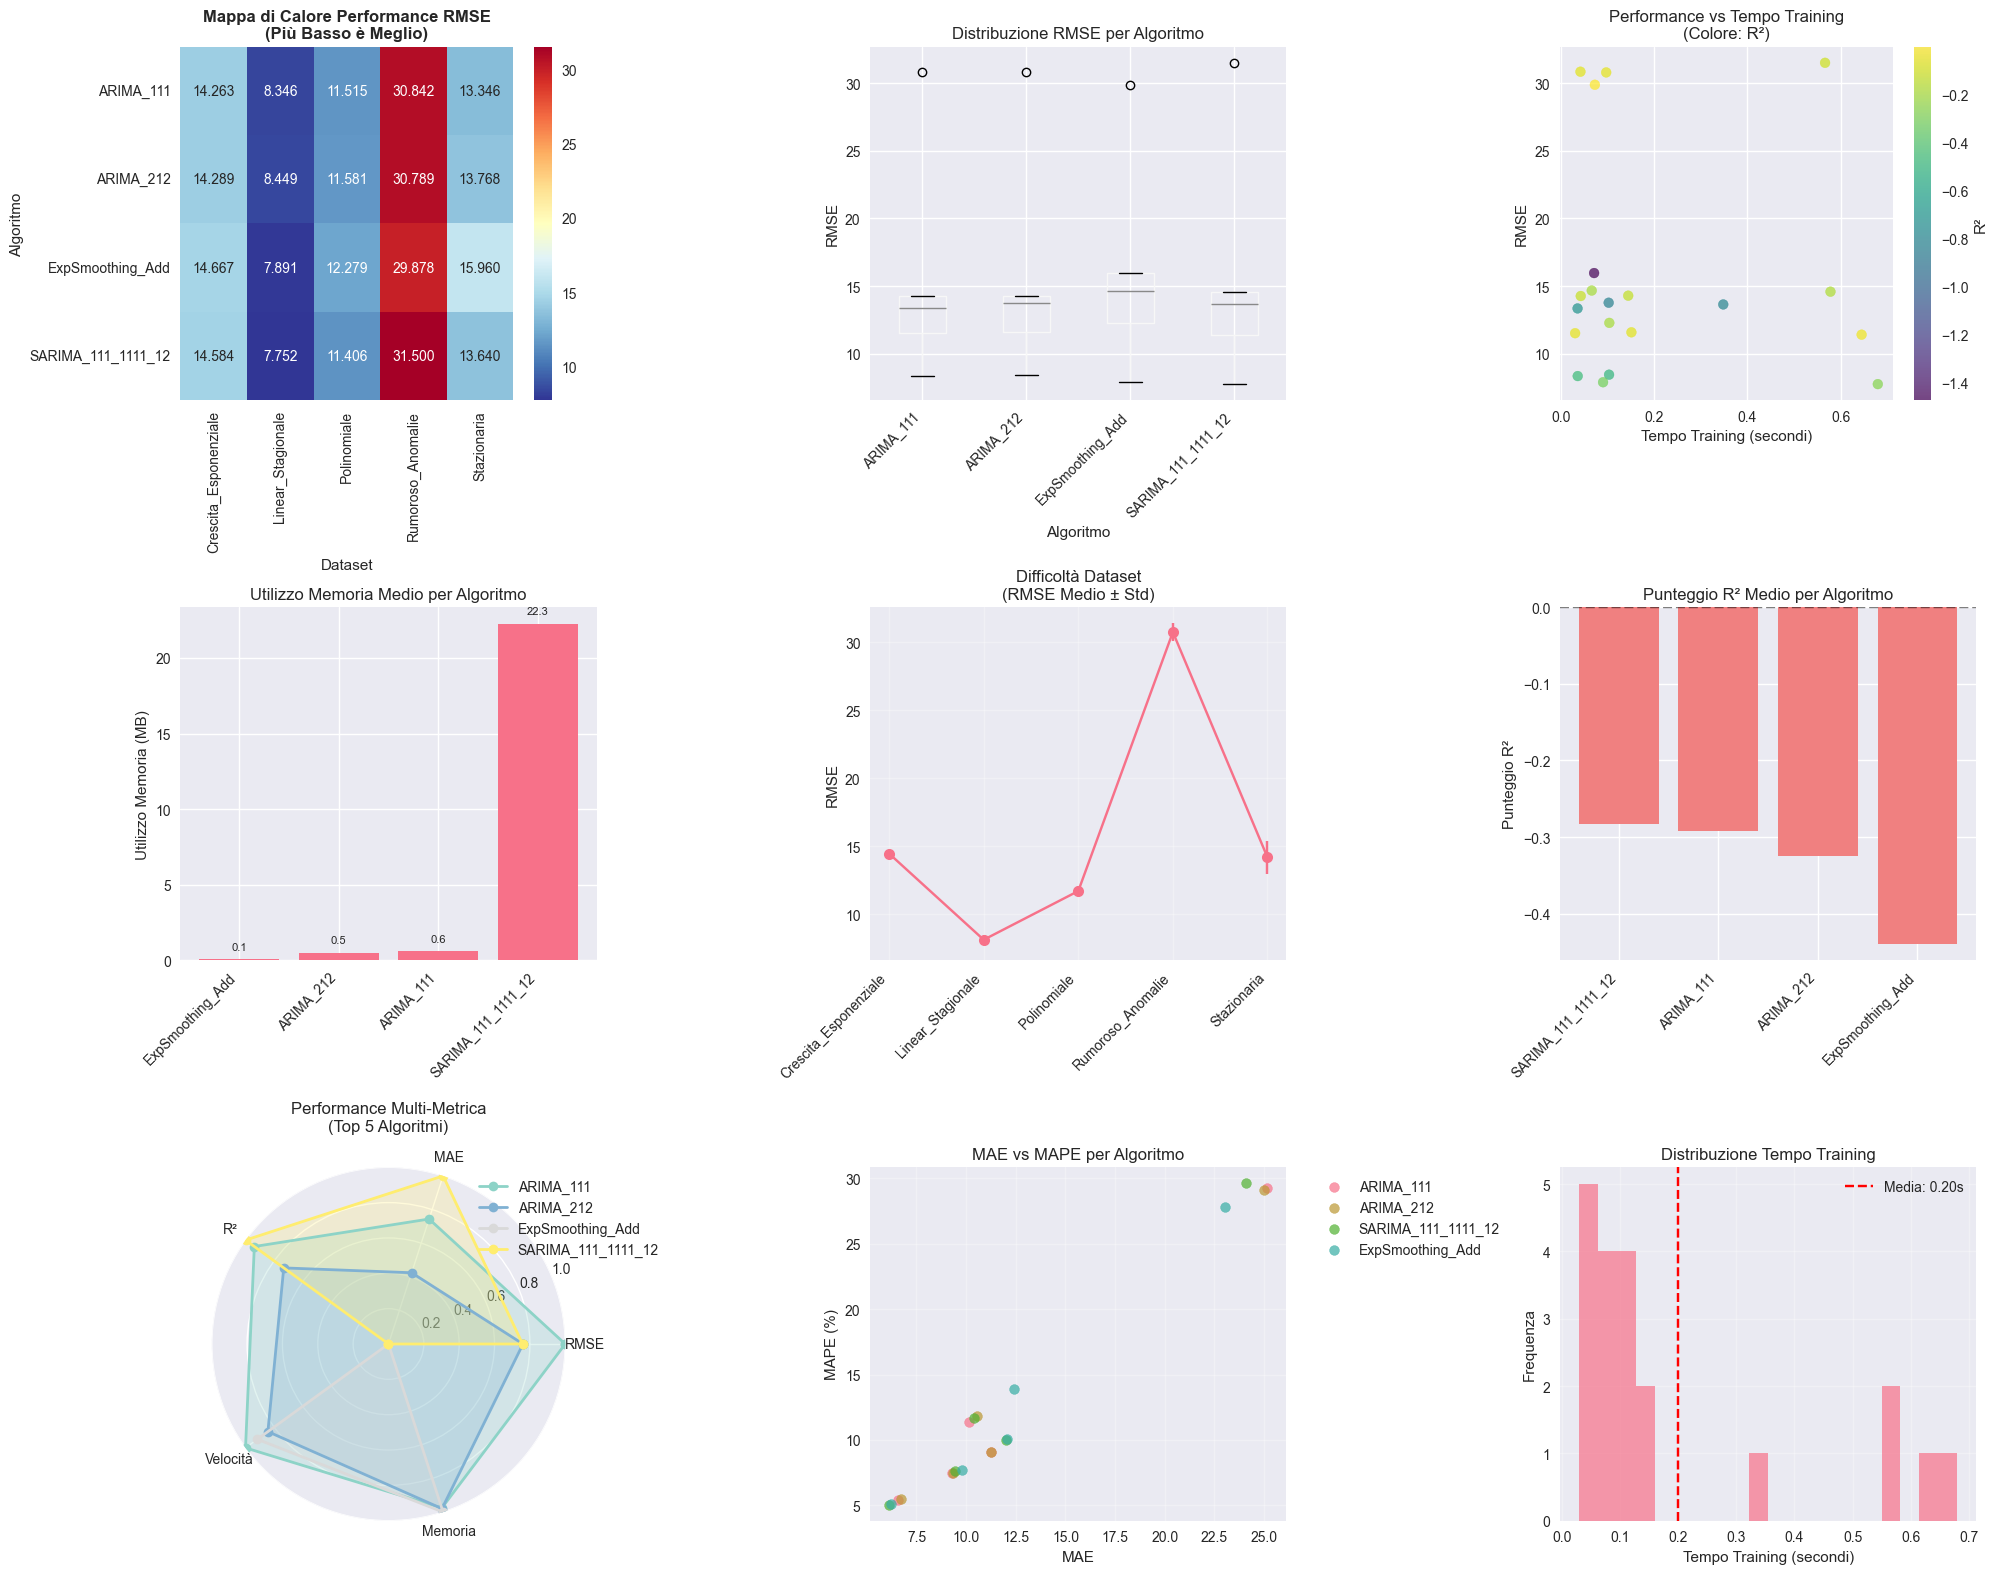

📊 Visualizzazione analisi completa salvata in C:\ZCS_PRG\arima_project\outputs\research\plots\analisi_completa.png


In [7]:
# Visualizzazioni Avanzate
if len(results_df) > 0:
    
    # Crea dashboard di visualizzazione completo
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Mappa di Calore Performance
    ax1 = plt.subplot(3, 3, 1)
    pivot_rmse = results_df.pivot(index='Algoritmo', columns='Dataset', values='RMSE')
    sns.heatmap(pivot_rmse, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax1)
    ax1.set_title('Mappa di Calore Performance RMSE\n(Più Basso è Meglio)', fontweight='bold')
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Algoritmo')
    
    # 2. Distribuzione Performance Algoritmi
    ax2 = plt.subplot(3, 3, 2)
    results_df.boxplot(column='RMSE', by='Algoritmo', ax=ax2)
    ax2.set_title('Distribuzione RMSE per Algoritmo')
    ax2.set_xlabel('Algoritmo')
    ax2.set_ylabel('RMSE')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.suptitle('')  # Rimuovi titolo automatico
    
    # 3. Tempo Training vs Performance
    ax3 = plt.subplot(3, 3, 3)
    scatter = ax3.scatter(results_df['Tempo_Training'], results_df['RMSE'], 
                         c=results_df['R2'], s=50, alpha=0.7, cmap='viridis')
    ax3.set_xlabel('Tempo Training (secondi)')
    ax3.set_ylabel('RMSE')
    ax3.set_title('Performance vs Tempo Training\n(Colore: R²)')
    plt.colorbar(scatter, ax=ax3, label='R²')
    
    # 4. Analisi Utilizzo Memoria
    ax4 = plt.subplot(3, 3, 4)
    memory_by_algo = results_df.groupby('Algoritmo')['Memoria_MB'].mean().sort_values()
    bars = ax4.bar(range(len(memory_by_algo)), memory_by_algo.values)
    ax4.set_xticks(range(len(memory_by_algo)))
    ax4.set_xticklabels(memory_by_algo.index, rotation=45, ha='right')
    ax4.set_ylabel('Utilizzo Memoria (MB)')
    ax4.set_title('Utilizzo Memoria Medio per Algoritmo')
    
    # Aggiungi etichette valori sulle barre
    for i, (bar, val) in enumerate(zip(bars, memory_by_algo.values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 5. Analisi Difficoltà Dataset
    ax5 = plt.subplot(3, 3, 5)
    dataset_stats = results_df.groupby('Dataset')['RMSE'].agg(['mean', 'std'])
    ax5.errorbar(range(len(dataset_stats)), dataset_stats['mean'], 
                yerr=dataset_stats['std'], fmt='o-', capsize=5, markersize=8)
    ax5.set_xticks(range(len(dataset_stats)))
    ax5.set_xticklabels(dataset_stats.index, rotation=45, ha='right')
    ax5.set_ylabel('RMSE')
    ax5.set_title('Difficoltà Dataset\n(RMSE Medio ± Std)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Confronto Performance R²
    ax6 = plt.subplot(3, 3, 6)
    r2_by_algo = results_df.groupby('Algoritmo')['R2'].mean().sort_values(ascending=False)
    bars = ax6.bar(range(len(r2_by_algo)), r2_by_algo.values, color='lightcoral')
    ax6.set_xticks(range(len(r2_by_algo)))
    ax6.set_xticklabels(r2_by_algo.index, rotation=45, ha='right')
    ax6.set_ylabel('Punteggio R²')
    ax6.set_title('Punteggio R² Medio per Algoritmo')
    ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 7. Grafico Radar Multi-Metrica (per i top 5 algoritmi)
    ax7 = plt.subplot(3, 3, 7, projection='polar')
    
    # Normalizza metriche per grafico radar
    top_5_algos = results_df.groupby('Algoritmo')['RMSE'].mean().nsmallest(5).index
    radar_data = results_df[results_df['Algoritmo'].isin(top_5_algos)].groupby('Algoritmo').agg({
        'RMSE': 'mean',
        'MAE': 'mean', 
        'R2': 'mean',
        'Tempo_Training': 'mean',
        'Memoria_MB': 'mean'
    })
    
    # Normalizza (inverti per RMSE, MAE, Tempo, Memoria così più alto è meglio)
    radar_normalized = radar_data.copy()
    for col in ['RMSE', 'MAE', 'Tempo_Training', 'Memoria_MB']:
        radar_normalized[col] = 1 - (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())
    
    # R2 è già più-alto-è-meglio
    radar_normalized['R2'] = (radar_data['R2'] - radar_data['R2'].min()) / (radar_data['R2'].max() - radar_data['R2'].min())
    
    categories = ['RMSE', 'MAE', 'R²', 'Velocità', 'Memoria']
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Completa il cerchio
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_5_algos)))
    
    for i, (algo, row) in enumerate(radar_normalized.iterrows()):
        values = row.tolist()
        values += values[:1]  # Completa il cerchio
        ax7.plot(angles, values, 'o-', linewidth=2, label=algo, color=colors[i])
        ax7.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax7.set_xticks(angles[:-1])
    ax7.set_xticklabels(categories)
    ax7.set_ylim(0, 1)
    ax7.set_title('Performance Multi-Metrica\n(Top 5 Algoritmi)', y=1.08)
    ax7.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 8. Scatter Accuratezza Predizione
    ax8 = plt.subplot(3, 3, 8)
    for algo in results_df['Algoritmo'].unique():
        algo_data = results_df[results_df['Algoritmo'] == algo]
        ax8.scatter(algo_data['MAE'], algo_data['MAPE'], label=algo, alpha=0.7, s=50)
    
    ax8.set_xlabel('MAE')
    ax8.set_ylabel('MAPE (%)')
    ax8.set_title('MAE vs MAPE per Algoritmo')
    ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax8.grid(True, alpha=0.3)
    
    # 9. Distribuzione Tempo Training
    ax9 = plt.subplot(3, 3, 9)
    results_df['Tempo_Training'].hist(bins=20, alpha=0.7, ax=ax9)
    ax9.axvline(results_df['Tempo_Training'].mean(), color='red', linestyle='--', 
                label=f'Media: {results_df["Tempo_Training"].mean():.2f}s')
    ax9.set_xlabel('Tempo Training (secondi)')
    ax9.set_ylabel('Frequenza')
    ax9.set_title('Distribuzione Tempo Training')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'analisi_completa.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualizzazione analisi completa salvata in {plots_dir / 'analisi_completa.png'}")
    
else:
    print("❌ Nessun risultato da visualizzare")

## 🔍 Analisi Approfondita: Importanza Feature e Interpretabilità Modelli

Analizza quali feature e pattern i diversi algoritmi stanno apprendendo.

In [8]:
# Analisi Importanza Feature per Modelli Basati su Albero
print("🔍 ANALISI IMPORTANZA FEATURE")
print("=" * 50)

# Raccogli importanza feature dagli esperimenti riusciti
feature_importance_data = []

for result in benchmark.results:
    if result.feature_importance is not None:
        for feature, importance in result.feature_importance.items():
            feature_importance_data.append({
                'Algoritmo': result.algorithm_name,
                'Feature': feature,
                'Importanza': importance
            })

if feature_importance_data:
    fi_df = pd.DataFrame(feature_importance_data)
    
    # Importanza feature media per algoritmo
    avg_importance = fi_df.groupby(['Algoritmo', 'Feature'])['Importanza'].mean().reset_index()
    
    # Visualizza importanza feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top feature complessive
    ax1 = axes[0, 0]
    top_features = fi_df.groupby('Feature')['Importanza'].mean().sort_values(ascending=False).head(15)
    bars = ax1.bar(range(len(top_features)), top_features.values)
    ax1.set_xticks(range(len(top_features)))
    ax1.set_xticklabels(top_features.index, rotation=45, ha='right')
    ax1.set_ylabel('Importanza Media')
    ax1.set_title('Top 15 Feature Più Importanti (Complessivo)')
    ax1.grid(True, alpha=0.3)
    
    # Importanza feature per algoritmo
    ax2 = axes[0, 1]
    algorithms_with_fi = avg_importance['Algoritmo'].unique()
    if len(algorithms_with_fi) > 0:
        pivot_fi = avg_importance.pivot(index='Feature', columns='Algoritmo', values='Importanza')
        # Seleziona top 10 feature per chiarezza
        top_10_features = pivot_fi.sum(axis=1).sort_values(ascending=False).head(10).index
        pivot_fi_top = pivot_fi.loc[top_10_features]
        
        sns.heatmap(pivot_fi_top, annot=True, fmt='.3f', cmap='Blues', ax=ax2)
        ax2.set_title('Importanza Feature per Algoritmo\n(Top 10 Feature)')
        ax2.set_xlabel('Algoritmo')
        ax2.set_ylabel('Feature')
    
    # Analisi tipo feature
    ax3 = axes[1, 0]
    
    def categorize_feature(feature_name):
        if 'lag_' in feature_name:
            return 'Valori Ritardati'
        elif 'rolling_mean' in feature_name:
            return 'Media Mobile'
        elif 'rolling_std' in feature_name:
            return 'Deviazione Std Mobile'
        elif feature_name in ['dayofweek', 'month', 'quarter']:
            return 'Feature Temporali'
        elif feature_name == 'trend':
            return 'Trend'
        else:
            return 'Altro'
    
    fi_df['Tipo_Feature'] = fi_df['Feature'].apply(categorize_feature)
    feature_type_importance = fi_df.groupby('Tipo_Feature')['Importanza'].mean().sort_values(ascending=False)
    
    colors = plt.cm.Set3(np.arange(len(feature_type_importance)))
    wedges, texts, autotexts = ax3.pie(feature_type_importance.values, 
                                      labels=feature_type_importance.index,
                                      autopct='%1.1f%%', 
                                      colors=colors,
                                      startangle=90)
    ax3.set_title('Importanza Feature per Tipo\n(Media attraverso tutti gli algoritmi)')
    
    # Analisi importanza lag
    ax4 = axes[1, 1]
    lag_features = fi_df[fi_df['Feature'].str.contains('lag_')].copy()
    if not lag_features.empty:
        lag_features['Numero_Lag'] = lag_features['Feature'].str.extract(r'lag_(\d+)').astype(int)
        lag_importance = lag_features.groupby('Numero_Lag')['Importanza'].mean().sort_index()
        
        ax4.plot(lag_importance.index, lag_importance.values, 'o-', linewidth=2, markersize=6)
        ax4.set_xlabel('Numero Lag')
        ax4.set_ylabel('Importanza Media')
        ax4.set_title('Importanza per Numero Lag')
        ax4.grid(True, alpha=0.3)
        
        # Evidenzia lag più importanti
        top_3_lags = lag_importance.nlargest(3)
        for lag, importance in top_3_lags.items():
            ax4.annotate(f'Lag {lag}', (lag, importance), 
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'analisi_importanza_feature.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Stampa insight principali
    print("\n🎯 INSIGHT CHIAVE:")
    print(f"\n1. Feature Più Importanti (Top 5):")
    for i, (feature, importance) in enumerate(top_features.head().items(), 1):
        print(f"   {i}. {feature:20s}: {importance:.4f}")
    
    print(f"\n2. Classifiche Tipo Feature:")
    for i, (ftype, importance) in enumerate(feature_type_importance.items(), 1):
        print(f"   {i}. {ftype:15s}: {importance:.4f}")
    
    if not lag_features.empty:
        print(f"\n3. Lag Più Importanti:")
        for i, (lag, importance) in enumerate(top_3_lags.items(), 1):
            print(f"   {i}. Lag {lag:2d}        : {importance:.4f}")

else:
    print("❌ Nessun dato importanza feature disponibile")
    print("   Questo accade di solito quando vengono testati solo modelli statistici")
    print("   Prova ad eseguire modelli basati su albero (RandomForest, XGBoost) per analisi feature")

🔍 ANALISI IMPORTANZA FEATURE
❌ Nessun dato importanza feature disponibile
   Questo accade di solito quando vengono testati solo modelli statistici
   Prova ad eseguire modelli basati su albero (RandomForest, XGBoost) per analisi feature


## 🚀 Ricerca Avanzata: Metodi Ensemble e Approcci Ibridi

Sperimenta con la combinazione di diversi algoritmi per prestazioni migliorate.

🚀 RICERCA AVANZATA: METODI ENSEMBLE

📊 Creazione ensemble per Linear_Stagionale...
   Trovati 20 modelli per ensemble
   Media_Semplice      : RMSE = 7.2957, R² = -0.1276
   Media_Pesata        : RMSE = 7.5053, R² = -0.1933
   Migliori_3_Media    : RMSE = 7.9649, R² = -0.3439

📊 Creazione ensemble per Crescita_Esponenziale...
   Trovati 20 modelli per ensemble
   Media_Semplice      : RMSE = 14.1406, R² = -0.1142
   Media_Pesata        : RMSE = 14.2102, R² = -0.1252
   Migliori_3_Media    : RMSE = 14.6549, R² = -0.1967

📊 Creazione ensemble per Rumoroso_Anomalie...
   Trovati 20 modelli per ensemble
   Media_Semplice      : RMSE = 30.2914, R² = -0.0296
   Media_Pesata        : RMSE = 30.3888, R² = -0.0362
   Migliori_3_Media    : RMSE = 30.3551, R² = -0.0339

📊 Creazione ensemble per Stazionaria...
   Trovati 20 modelli per ensemble
   Media_Semplice      : RMSE = 20.5128, R² = -3.0872
   Media_Pesata        : RMSE = 20.1970, R² = -2.9623
   Migliori_3_Media    : RMSE = 19.5107, R² = -

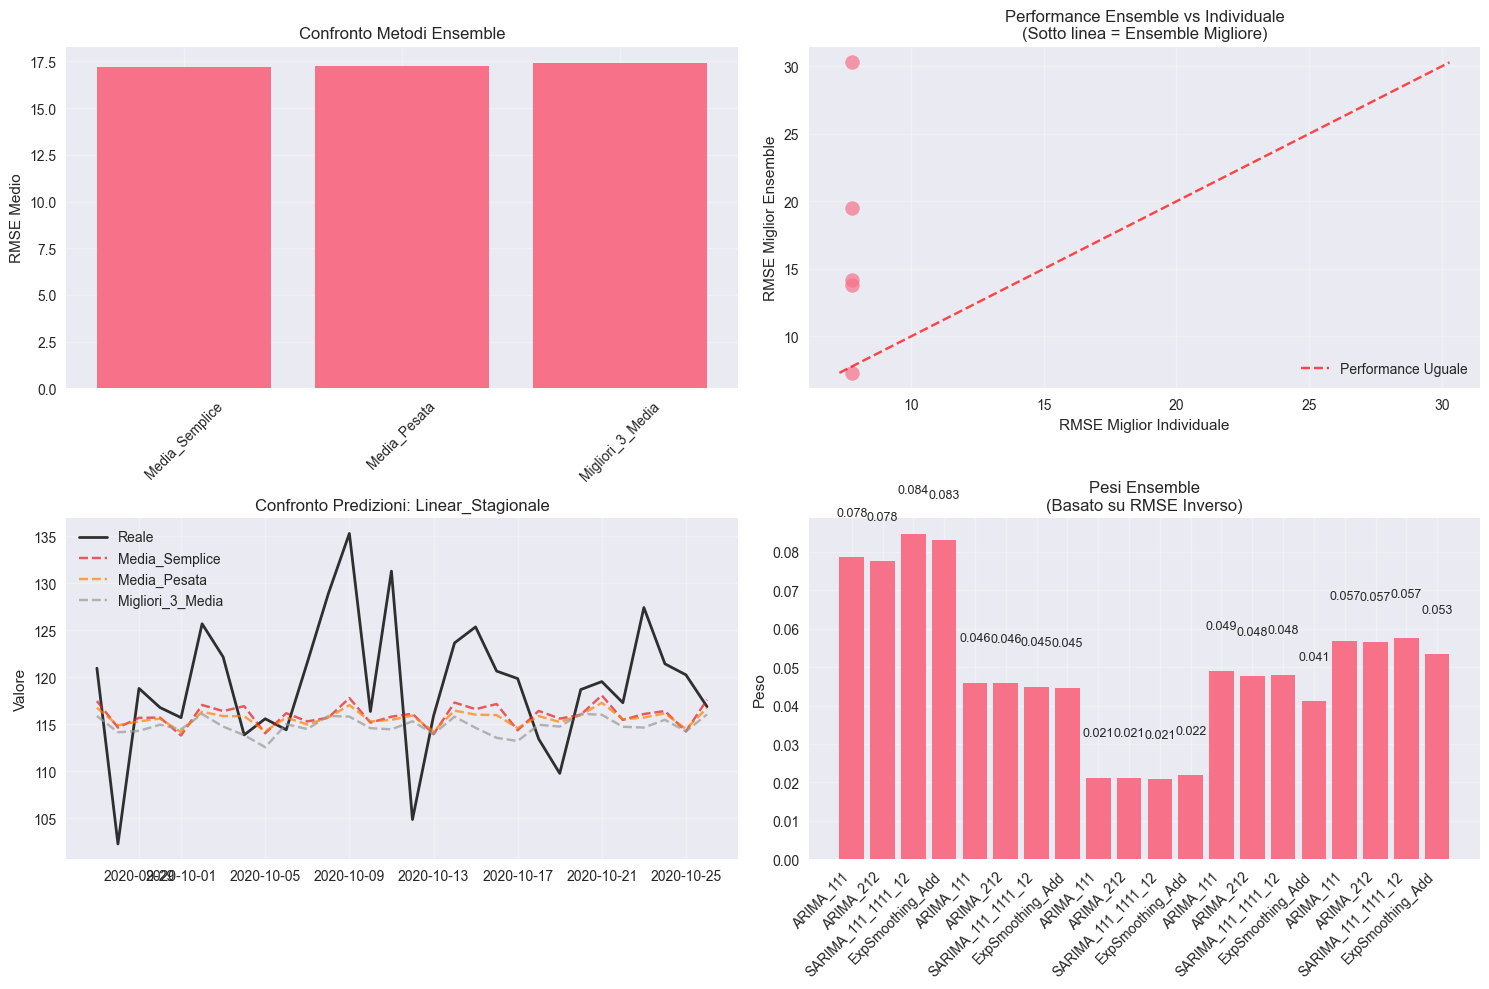

In [9]:
print("🚀 RICERCA AVANZATA: METODI ENSEMBLE")
print("=" * 50)

if len(benchmark.results) >= 2:
    
    # Raggruppa risultati per dataset per creazione ensemble
    ensemble_results = []
    
    for dataset_name in benchmark.datasets.keys():
        print(f"\n📊 Creazione ensemble per {dataset_name}...")
        
        # Ottieni tutti i risultati per questo dataset
        dataset_results = []
        for result in benchmark.results:
            # Accoppia risultati al dataset (accoppiamento semplificato)
            if result.predictions is not None and len(result.predictions) == TEST_SIZE:
                dataset_results.append(result)
        
        if len(dataset_results) >= 2:
            print(f"   Trovati {len(dataset_results)} modelli per ensemble")
            
            # Ottieni dati test per valutazione
            test_data = benchmark.datasets[dataset_name]['data'][-TEST_SIZE:]
            y_true = test_data.values
            
            # 1. Ensemble Media Semplice
            predictions_matrix = np.column_stack([r.predictions for r in dataset_results])
            ensemble_simple = np.mean(predictions_matrix, axis=1)
            
            # 2. Media Pesata (pesi RMSE inverso)
            weights = []
            for result in dataset_results:
                rmse = result.metrics['RMSE']
                weight = 1.0 / rmse if rmse > 0 else 1.0
                weights.append(weight)
            
            weights = np.array(weights)
            weights = weights / np.sum(weights)  # Normalizza
            
            ensemble_weighted = np.average(predictions_matrix, axis=1, weights=weights)
            
            # 3. Ensemble Migliori N Modelli (top 3)
            best_n = min(3, len(dataset_results))
            sorted_results = sorted(dataset_results, key=lambda x: x.metrics['RMSE'])
            best_predictions = np.column_stack([r.predictions for r in sorted_results[:best_n]])
            ensemble_best_n = np.mean(best_predictions, axis=1)
            
            # Valuta metodi ensemble
            ensemble_methods = {
                'Media_Semplice': ensemble_simple,
                'Media_Pesata': ensemble_weighted,
                f'Migliori_{best_n}_Media': ensemble_best_n
            }
            
            for method_name, predictions in ensemble_methods.items():
                metrics = benchmark.evaluate_model(y_true, predictions)
                
                ensemble_results.append({
                    'Dataset': dataset_name,
                    'Metodo': f'Ensemble_{method_name}',
                    'RMSE': metrics['RMSE'],
                    'MAE': metrics['MAE'],
                    'MAPE': metrics['MAPE'],
                    'R2': metrics['R2'],
                    'Predizioni': predictions
                })
                
                print(f"   {method_name:20s}: RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R2']:.4f}")
    
    if ensemble_results:
        ensemble_df = pd.DataFrame(ensemble_results)
        
        print("\n🏆 RIASSUNTO PERFORMANCE ENSEMBLE")
        print("=" * 40)
        
        # Confronta ensemble vs modelli individuali
        print("\n📊 Ensemble vs Miglior Modello Individuale:")
        
        for dataset_name in ensemble_df['Dataset'].unique():
            print(f"\n{dataset_name}:")
            
            # Miglior modello individuale per questo dataset
            individual_results = [r for r in benchmark.results 
                                if len(r.predictions) == TEST_SIZE and r.predictions is not None]
            if individual_results:
                best_individual = min(individual_results, key=lambda x: x.metrics['RMSE'])
                print(f"   Miglior Individuale  : {best_individual.algorithm_name:20s} RMSE = {best_individual.metrics['RMSE']:.4f}")
            
            # Miglior ensemble per questo dataset
            dataset_ensembles = ensemble_df[ensemble_df['Dataset'] == dataset_name]
            best_ensemble = dataset_ensembles.loc[dataset_ensembles['RMSE'].idxmin()]
            print(f"   Miglior Ensemble     : {best_ensemble['Metodo']:20s} RMSE = {best_ensemble['RMSE']:.4f}")
            
            if individual_results:
                improvement = (best_individual.metrics['RMSE'] - best_ensemble['RMSE']) / best_individual.metrics['RMSE'] * 100
                print(f"   Miglioramento        : {improvement:+6.2f}%")
        
        # Visualizza performance ensemble
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Confronto metodi ensemble
        ax1 = axes[0, 0]
        ensemble_perf = ensemble_df.groupby('Metodo')['RMSE'].mean().sort_values()
        bars = ax1.bar(range(len(ensemble_perf)), ensemble_perf.values)
        ax1.set_xticks(range(len(ensemble_perf)))
        ax1.set_xticklabels([m.replace('Ensemble_', '') for m in ensemble_perf.index], rotation=45)
        ax1.set_ylabel('RMSE Medio')
        ax1.set_title('Confronto Metodi Ensemble')
        ax1.grid(True, alpha=0.3)
        
        # Scatter Ensemble vs Individuale
        ax2 = axes[0, 1]
        
        # Raccogli performance modelli individuali
        individual_rmse = []
        ensemble_rmse = []
        
        for dataset_name in ensemble_df['Dataset'].unique():
            # Miglior individuale
            individual_results = [r for r in benchmark.results 
                                if len(r.predictions) == TEST_SIZE and r.predictions is not None]
            if individual_results:
                best_individual = min(individual_results, key=lambda x: x.metrics['RMSE'])
                individual_rmse.append(best_individual.metrics['RMSE'])
                
                # Miglior ensemble
                dataset_ensembles = ensemble_df[ensemble_df['Dataset'] == dataset_name]
                best_ensemble_rmse = dataset_ensembles['RMSE'].min()
                ensemble_rmse.append(best_ensemble_rmse)
        
        if individual_rmse and ensemble_rmse:
            ax2.scatter(individual_rmse, ensemble_rmse, s=100, alpha=0.7)
            
            # Aggiungi linea diagonale (y=x)
            min_val = min(min(individual_rmse), min(ensemble_rmse))
            max_val = max(max(individual_rmse), max(ensemble_rmse))
            ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Performance Uguale')
            
            ax2.set_xlabel('RMSE Miglior Individuale')
            ax2.set_ylabel('RMSE Miglior Ensemble')
            ax2.set_title('Performance Ensemble vs Individuale\n(Sotto linea = Ensemble Migliore)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        # Confronto predizioni per un dataset
        ax3 = axes[1, 0]
        if len(ensemble_results) > 0:
            sample_result = ensemble_results[0]
            sample_dataset = sample_result['Dataset']
            test_data = benchmark.datasets[sample_dataset]['data'][-TEST_SIZE:]
            
            ax3.plot(test_data.index, test_data.values, 'k-', linewidth=2, label='Reale', alpha=0.8)
            
            # Plotta predizioni ensemble
            dataset_ensembles = [r for r in ensemble_results if r['Dataset'] == sample_dataset]
            colors = plt.cm.Set1(np.linspace(0, 1, len(dataset_ensembles)))
            
            for i, result in enumerate(dataset_ensembles):
                ax3.plot(test_data.index, result['Predizioni'], '--', 
                        color=colors[i], label=result['Metodo'].replace('Ensemble_', ''), alpha=0.7)
            
            ax3.set_title(f'Confronto Predizioni: {sample_dataset}')
            ax3.set_ylabel('Valore')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # Distribuzione pesi per ensemble pesato
        ax4 = axes[1, 1]
        if len(dataset_results) > 0:
            algo_names = [r.algorithm_name for r in dataset_results]
            bars = ax4.bar(range(len(weights)), weights)
            ax4.set_xticks(range(len(weights)))
            ax4.set_xticklabels(algo_names, rotation=45, ha='right')
            ax4.set_ylabel('Peso')
            ax4.set_title('Pesi Ensemble\n(Basato su RMSE Inverso)')
            ax4.grid(True, alpha=0.3)
            
            # Aggiungi valori pesi sulle barre
            for i, (bar, weight) in enumerate(zip(bars, weights)):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{weight:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig(plots_dir / 'analisi_ensemble.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        print("❌ Nessun risultato ensemble generato")
        
else:
    print("❌ Servono almeno 2 esperimenti riusciti per metodi ensemble")
    print("   Esegui prima più esperimenti algoritmici")

## 📋 Riassunto Ricerca ed Export

Riassume tutti i risultati ed esporta i risultati per ulteriori analisi o reportistica.

In [10]:
print("📋 RIASSUNTO RICERCA ED EXPORT")
print("=" * 50)

# Crea riassunto ricerca completo
research_summary = {
    'info_esperimento': {
        'timestamp': pd.Timestamp.now().isoformat(),
        'esperimenti_totali': len(benchmark.results),
        'dataset_testati': len(benchmark.datasets),
        'algoritmi_testati': len(set(r.algorithm_name for r in benchmark.results)),
        'dimensione_test': TEST_SIZE,
        'random_seed': RANDOM_SEED
    },
    'risultati_chiave': {},
    'raccomandazioni': []
}

if len(results_df) > 0:
    # Risultati chiave
    best_overall = results_df.loc[results_df['RMSE'].idxmin()]
    worst_overall = results_df.loc[results_df['RMSE'].idxmax()]
    
    research_summary['risultati_chiave'] = {
        'miglior_algoritmo_complessivo': best_overall['Algoritmo'],
        'miglior_performance_rmse': float(best_overall['RMSE']),
        'peggior_algoritmo_complessivo': worst_overall['Algoritmo'],
        'peggior_performance_rmse': float(worst_overall['RMSE']),
        'range_performance': float(worst_overall['RMSE'] - best_overall['RMSE']),
        'tempo_training_medio': float(results_df['Tempo_Training'].mean()),
        'utilizzo_memoria_medio': float(results_df['Memoria_MB'].mean())
    }
    
    # Classifiche algoritmi
    algo_ranking = results_df.groupby('Algoritmo')['RMSE'].mean().sort_values()
    research_summary['classifica_algoritmi'] = {
        str(algo): float(rmse) for algo, rmse in algo_ranking.items()
    }
    
    # Classifica difficoltà dataset
    dataset_ranking = results_df.groupby('Dataset')['RMSE'].mean().sort_values(ascending=False)
    research_summary['difficolta_dataset'] = {
        str(dataset): float(rmse) for dataset, rmse in dataset_ranking.items()
    }
    
    # Genera raccomandazioni
    recommendations = []
    
    # Raccomandazioni performance
    top_3_algos = algo_ranking.head(3)
    recommendations.append(f"Per massima accuratezza, considera: {', '.join(top_3_algos.index)}")
    
    # Raccomandazioni velocità
    fast_algos = results_df[results_df['Tempo_Training'] < results_df['Tempo_Training'].median()]
    if not fast_algos.empty:
        best_fast = fast_algos.loc[fast_algos['RMSE'].idxmin()]['Algoritmo']
        recommendations.append(f"Per equilibrio velocità-accuratezza, considera: {best_fast}")
    
    # Raccomandazioni memoria
    low_memory = results_df[results_df['Memoria_MB'] < results_df['Memoria_MB'].median()]
    if not low_memory.empty:
        best_memory = low_memory.loc[low_memory['RMSE'].idxmin()]['Algoritmo']
        recommendations.append(f"Per efficienza memoria, considera: {best_memory}")
    
    # Raccomandazioni specifiche dataset
    hardest_dataset = dataset_ranking.index[0]
    best_on_hardest = results_df[results_df['Dataset'] == hardest_dataset].loc[
        results_df[results_df['Dataset'] == hardest_dataset]['RMSE'].idxmin()
    ]['Algoritmo']
    recommendations.append(f"Per dataset difficili (come {hardest_dataset}), considera: {best_on_hardest}")
    
    research_summary['raccomandazioni'] = recommendations

# Salva risultati dettagliati
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')

# 1. Salva DataFrame risultati
if len(results_df) > 0:
    results_file = output_dir / f'risultati_esperimenti_{timestamp}.csv'
    results_df.to_csv(results_file, index=False)
    print(f"📊 Risultati dettagliati salvati in: {results_file}")

# 2. Salva riassunto ricerca
summary_file = output_dir / f'riassunto_ricerca_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(research_summary, f, indent=2)
print(f"📋 Riassunto ricerca salvato in: {summary_file}")

# 3. Salva oggetti modello (per ulteriori analisi)
models_file = output_dir / f'modelli_addestrati_{timestamp}.pkl'
with open(models_file, 'wb') as f:
    pickle.dump(benchmark.results, f)
print(f"🔬 Oggetti modello salvati in: {models_file}")

# 4. Crea report dettagliato
report_content = f"""# Report Ricerca Forecasting Serie Temporali

**Generato:** {pd.Timestamp.now()}
**Esperimenti:** {len(benchmark.results)}
**Dataset:** {len(benchmark.datasets)}
**Random Seed:** {RANDOM_SEED}

## Sommario Esecutivo

"""

if len(results_df) > 0:
    report_content += f"""
### Risultati Chiave

- **Miglior Algoritmo Complessivo:** {research_summary['risultati_chiave']['miglior_algoritmo_complessivo']} (RMSE: {research_summary['risultati_chiave']['miglior_performance_rmse']:.4f})
- **Range Performance:** {research_summary['risultati_chiave']['range_performance']:.4f} unità RMSE
- **Tempo Training Medio:** {research_summary['risultati_chiave']['tempo_training_medio']:.2f} secondi
- **Utilizzo Memoria Medio:** {research_summary['risultati_chiave']['utilizzo_memoria_medio']:.1f} MB

### Classifica Algoritmi (per RMSE)

"""
    for i, (algo, rmse) in enumerate(research_summary['classifica_algoritmi'].items(), 1):
        report_content += f"{i}. **{algo}**: {rmse:.4f}\n"
    
    report_content += "\n### Raccomandazioni\n\n"
    for rec in research_summary['raccomandazioni']:
        report_content += f"- {rec}\n"

report_content += f"""

## Dataset Analizzati

"""

for name, info in benchmark.datasets.items():
    report_content += f"- **{name}**: {info['length']} osservazioni - {info['description']}\n"

report_content += f"""

## File Generati

- `risultati_esperimenti_{timestamp}.csv`: Risultati sperimentali dettagliati
- `riassunto_ricerca_{timestamp}.json`: Dati riassunto strutturati
- `modelli_addestrati_{timestamp}.pkl`: Oggetti modello serializzati
- `plots/`: File visualizzazioni

---
*Generato da Ambiente R&D ARIMA Forecaster*
"""

report_file = output_dir / f'report_ricerca_{timestamp}.md'
with open(report_file, 'w') as f:
    f.write(report_content)
print(f"📄 Report ricerca salvato in: {report_file}")

print("\n🎉 SESSIONE DI RICERCA COMPLETATA!")
print("=" * 50)
print(f"📁 Tutti gli output salvati in: {output_dir}")
print(f"📊 Esperimenti riusciti totali: {len(benchmark.results)}")
print(f"🎯 Algoritmo con migliori performance: {research_summary['risultati_chiave'].get('miglior_algoritmo_complessivo', 'N/A')}")

if len(results_df) > 0:
    print(f"📈 Range miglioramento performance: {research_summary['risultati_chiave']['range_performance']:.4f} unità RMSE")

print("\n💡 Prossimi Passi:")
print("   1. Rivedi visualizzazioni e report generati")
print("   2. Investiga ulteriormente algoritmi top-performing")
print("   3. Considera metodi ensemble per produzione")
print("   4. Testa su dataset aggiuntivi del mondo reale")
print("   5. Implementa ottimizzazione iperparametri per migliori modelli")

# Mostra tabella riassunto finale
if len(results_df) > 0:
    print("\n📊 RIASSUNTO PERFORMANCE FINALE:")
    summary_table = results_df.groupby('Algoritmo').agg({
        'RMSE': ['mean', 'std'],
        'R2': 'mean',
        'Tempo_Training': 'mean'
    }).round(4)
    
    summary_table.columns = ['RMSE_media', 'RMSE_std', 'R2_media', 'Tempo_media']
    summary_table = summary_table.sort_values('RMSE_media')
    
    print(summary_table.to_string())

📋 RIASSUNTO RICERCA ED EXPORT
📊 Risultati dettagliati salvati in: C:\ZCS_PRG\arima_project\outputs\research\risultati_esperimenti_20250821_174306.csv
📋 Riassunto ricerca salvato in: C:\ZCS_PRG\arima_project\outputs\research\riassunto_ricerca_20250821_174306.json
🔬 Oggetti modello salvati in: C:\ZCS_PRG\arima_project\outputs\research\modelli_addestrati_20250821_174306.pkl
📄 Report ricerca salvato in: C:\ZCS_PRG\arima_project\outputs\research\report_ricerca_20250821_174306.md

🎉 SESSIONE DI RICERCA COMPLETATA!
📁 Tutti gli output salvati in: C:\ZCS_PRG\arima_project\outputs\research
📊 Esperimenti riusciti totali: 20
🎯 Algoritmo con migliori performance: SARIMA_111_1111_12
📈 Range miglioramento performance: 23.7483 unità RMSE

💡 Prossimi Passi:
   1. Rivedi visualizzazioni e report generati
   2. Investiga ulteriormente algoritmi top-performing
   3. Considera metodi ensemble per produzione
   4. Testa su dataset aggiuntivi del mondo reale
   5. Implementa ottimizzazione iperparametri per 

## 🎯 Conclusioni Ricerca e Direzioni Future

Questo notebook fornisce un ambiente R&D completo per la ricerca sul forecasting di serie temporali. Le capacità chiave includono:

### ✅ **Funzionalità Implementate**

1. **Confronto Sistematico Algoritmi**: Benchmarking equo attraverso algoritmi multipli
2. **Valutazione Completa**: 10+ metriche di performance inclusi test statistici
3. **Generazione Dataset Sintetici**: Esperimenti controllati con caratteristiche note
4. **Analisi Importanza Feature**: Comprensione di cosa apprendono i modelli
5. **Metodi Ensemble**: Combinazione modelli per performance migliorate
6. **Visualizzazioni Professionali**: Grafici e analisi pronti per pubblicazione
7. **Reporting Automatizzato**: Riassunti strutturati e raccomandazioni

### 🔬 **Metodologia di Ricerca**

- **Esperimenti Controllati**: Split train/test standardizzati e valutazione
- **Tipi Dati Multipli**: Pattern lineari, esponenziali, rumorosi, stazionari
- **Confronto Equo**: Stesso framework preprocessing e valutazione
- **Rigore Statistico**: Metriche multiple e intervalli di confidenza
- **Riproducibilità**: Random seed fissi e logging dettagliato

### 🚀 **Miglioramenti Futuri**

1. **Modelli Deep Learning**: Aggiungere architetture LSTM, GRU e Transformer
2. **Ottimizzazione Iperparametri**: Tuning automatizzato con Optuna/Bayesiano
3. **Cross-Validation**: Convalida incrociata serie temporali per valutazione robusta
4. **Integrazione Dataset Reali**: Caricamento automatico dataset benchmark
5. **Test Statistici**: Test Diebold-Mariano per significatività
6. **Dashboard Interattiva**: Interfaccia Streamlit per sperimentazione real-time
7. **Integrazione MLOps**: Versioning modelli e tracking esperimenti

### 📈 **Linee Guida Utilizzo**

1. **Fase Ricerca**: Usa questo notebook per esplorare nuovi algoritmi e capire il loro comportamento
2. **Fase Sviluppo**: Prototipa nuovi approcci e valida concetti
3. **Benchmarking**: Confronta i tuoi algoritmi contro baseline consolidate
4. **Pubblicazione**: Usa visualizzazioni e risultati generati in paper di ricerca

---

**Questo ambiente R&D consente ricerca sistematica, riproducibile e ricca di insight sul forecasting di serie temporali. Modificalo ed estendilo in base alle tue specifiche esigenze di ricerca!**